# Importing the Libraries

In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report

## We load the data with glob



In [2]:
fire_folder  = r"fire_dataset\fire_images/*.png"
non_fire_folder = r"fire_dataset\non_fire_images/*.png"

In [3]:
lst_fire_img = glob.glob(fire_folder)
lst_non_fire_img = glob.glob(non_fire_folder)

In [4]:
lst_non_fire_img

['fire_dataset\\non_fire_images\\non_fire.1.png',
 'fire_dataset\\non_fire_images\\non_fire.10.png',
 'fire_dataset\\non_fire_images\\non_fire.100.png',
 'fire_dataset\\non_fire_images\\non_fire.101.png',
 'fire_dataset\\non_fire_images\\non_fire.102.png',
 'fire_dataset\\non_fire_images\\non_fire.103.png',
 'fire_dataset\\non_fire_images\\non_fire.104.png',
 'fire_dataset\\non_fire_images\\non_fire.105.png',
 'fire_dataset\\non_fire_images\\non_fire.106.png',
 'fire_dataset\\non_fire_images\\non_fire.107.png',
 'fire_dataset\\non_fire_images\\non_fire.108.png',
 'fire_dataset\\non_fire_images\\non_fire.109.png',
 'fire_dataset\\non_fire_images\\non_fire.11.png',
 'fire_dataset\\non_fire_images\\non_fire.110.png',
 'fire_dataset\\non_fire_images\\non_fire.111.png',
 'fire_dataset\\non_fire_images\\non_fire.112.png',
 'fire_dataset\\non_fire_images\\non_fire.113.png',
 'fire_dataset\\non_fire_images\\non_fire.114.png',
 'fire_dataset\\non_fire_images\\non_fire.115.png',
 'fire_dataset\\

In [5]:
print('Number of images with fire : {}'.format(len(lst_fire_img)))
print('Number of images with fire : {}'.format(len(lst_non_fire_img)))

Number of images with fire : 755
Number of images with fire : 243


#### We plot 20 images to see how are the data



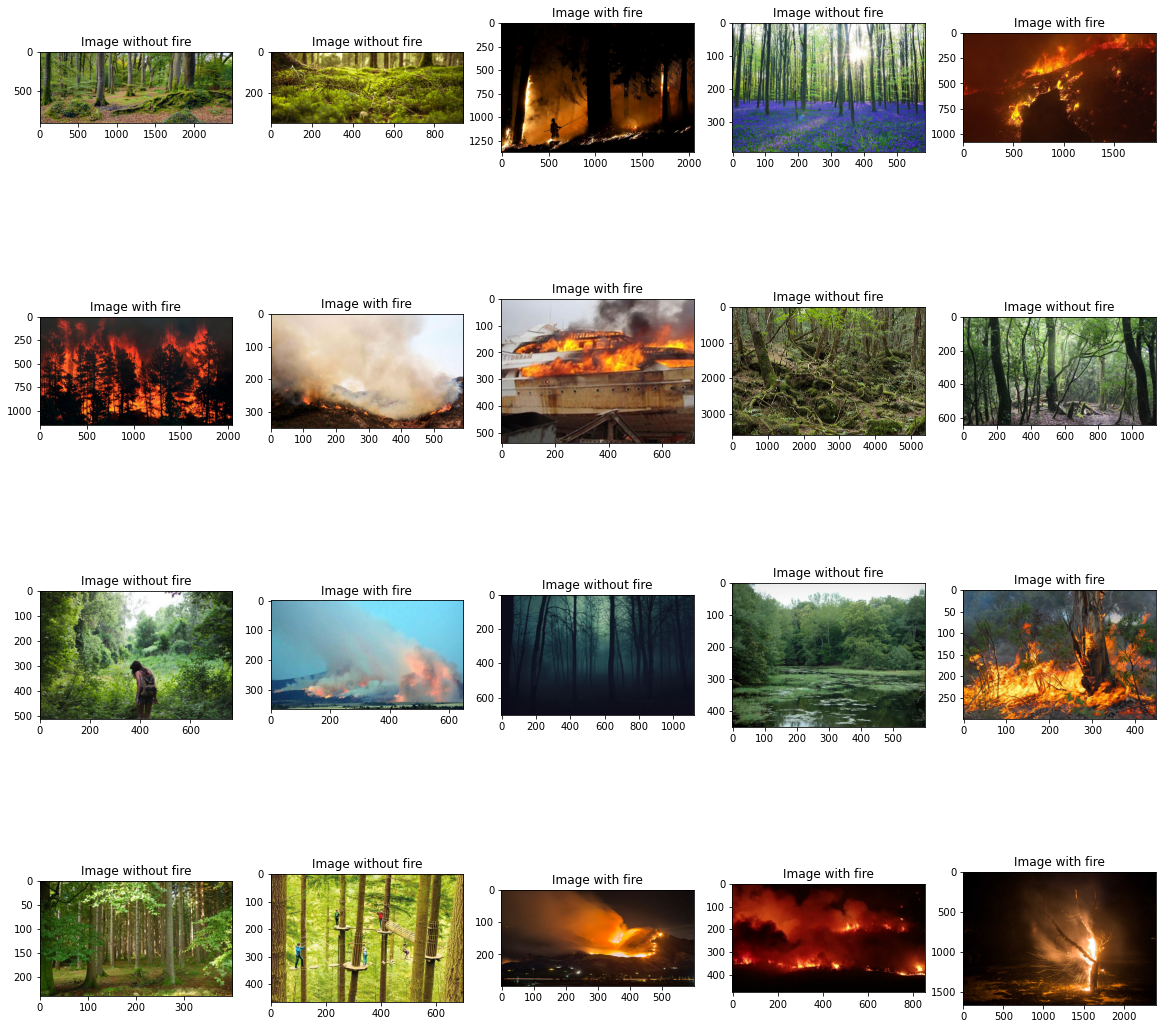

In [6]:
lst_images_random = random.sample(lst_fire_img,10) + random.sample(lst_non_fire_img,10)
random.shuffle(lst_images_random)

plt.figure(figsize = (20,20))

for i in range(len(lst_images_random)):
    
    plt.subplot(4,5,i+1)


    if "non_fire" in lst_images_random[i]:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title('Image without fire')

    else:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title("Image with fire")



plt.show()

### We create a dataframe with filepath images and label (1 = fire , 0 = without fire)



In [7]:
lst_fire = []
for x in lst_fire_img:
  lst_fire.append([x,1])
lst_nn_fire = []
for x in lst_non_fire_img:
  lst_nn_fire.append([x,0])
lst_complete = lst_fire + lst_nn_fire
random.shuffle(lst_complete)

In [8]:
df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)

,files,target
0,fire_dataset\non_fire_images\non_fire.112.png,0
1,fire_dataset\fire_images\fire.208.png,1
2,fire_dataset\fire_images\fire.511.png,1
3,fire_dataset\non_fire_images\non_fire.180.png,0
4,fire_dataset\fire_images\fire.325.png,1
5,fire_dataset\non_fire_images\non_fire.26.png,0
6,fire_dataset\fire_images\fire.25.png,1
7,fire_dataset\fire_images\fire.444.png,1
8,fire_dataset\fire_images\fire.366.png,1
9,fire_dataset\fire_images\fire.204.png,1


### We have a problem with image 189 in non_fire_images so we drop it

In [9]:
filepath_img = r"fire_dataset\non_fire_images/non_fire_189.png"

df = df.loc[~(df.loc[:,'files'] == filepath_img),:]

In [10]:
df.shape

(998, 2)

### Although we can see that the dataset is uneven, we do not utilise ImageDataGenerator because the results are still quite decent.


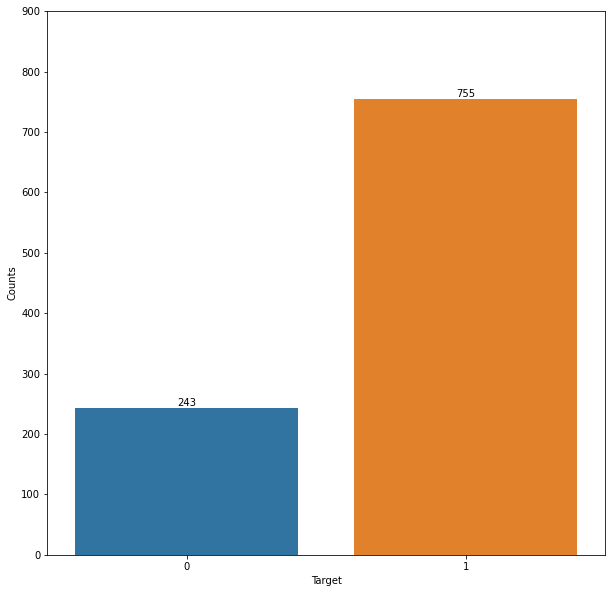

In [11]:
fig = plt.figure(figsize=(10,10)) 
plt.ylim(0,900)
ax = sns.countplot(x=df['target'])

plt.xlabel('Target')
plt.ylabel('Counts')


# Annotating the bar graph
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.show()

## We preprocess all the images



In [13]:
def preprocessing_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    if img is not None:
        # Perform preprocessing steps on the loaded image
        # For example, resizing and color conversion can be done here
        img = cv2.resize(img, (196, 196))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale, adjust as needed
        img=img / 255 #scale
        return img
    else:
        # Handle the case where the image cannot be loaded
        # You can return None or perform other error handling actions
        print(f"Warning: Unable to load image at path {image_path}")
        return None

#### We create numpy array X and y . X are 998 images with (196,196,3) shape, y the target is (998,) shape

In [15]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [16]:
X, y = create_format_dataset(df)

In [17]:
X.shape,y.shape

((998, 196, 196), (998,))

### we split the data in train and test


In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [19]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((698, 196, 196), (300, 196, 196), (698,), (300,))

In [20]:
model = Sequential()

model.add(Conv2D(128,(2,2),input_shape = (196,196,3),activation='relu'))
model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1,activation= "sigmoid"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 195, 195, 128)     1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 194, 194, 64)      32832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 97, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 73728)             0

In [22]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\cflun\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\cflun\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cflun\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\cflun\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\cflun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\cflun\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 196, 196)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 196, 196), dtype=float32)
      • training=True
      • mask=None
